## This notebook reads data from our in-house Climate Forecast System Reanalysis repository and plots fields of interest from it.  It also illustrates the use of MetPy's `calc` library which allows one to compute derived quantitites, such as advection, divergence, vorticity, frontogenesis, and many others!
### Reference: https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.html



# <span style="color:purple">0) Preliminaries </span>

In [2]:
import xarray as xr
import pandas as pd
import numpy as np
from datetime import datetime as dt
from metpy.units import units
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter

/tmp/ipykernel_9720/737351134.py:10: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


# <span style="color:purple">1) Specify a starting and ending date/time, and access several CFSR Datasets</span>

In [3]:
startYear = 2013
startMonth = 3
startDay = 20
startHour = 0
startMinute = 0
startDateTime = dt(startYear,startMonth,startDay, startHour, startMinute)

endYear = 2013
endMonth = 3
endDay = 20
endHour = 21
endMinute = 0
endDateTime = dt(endYear,endMonth,endDay, endHour, endMinute)


### The CFSR updates daily; most likely though, the current date will not be available. So go back one day if the latest data is desired.

### Create Xarray `Dataset` objects

In [4]:
dsZ = xr.open_dataset ('/cfsr/data/%s/g.%s.0p5.anl.nc' % (startYear, startYear))
dsT = xr.open_dataset ('/cfsr/data/%s/t.%s.0p5.anl.nc' % (startYear, startYear))
dsU = xr.open_dataset ('/cfsr/data/%s/u.%s.0p5.anl.nc' % (startYear, startYear))
dsV = xr.open_dataset ('/cfsr/data/%s/v.%s.0p5.anl.nc' % (startYear, startYear))
dsW = xr.open_dataset ('/cfsr/data/%s/w.%s.0p5.anl.nc' % (startYear, startYear))
dsQ = xr.open_dataset ('/cfsr/data/%s/q.%s.0p5.anl.nc' % (startYear, startYear))
dsSLP = xr.open_dataset ('/cfsr/data/%s/pmsl.%s.0p5.anl.nc' % (startYear, startYear))

# <span style="color:purple">2) Specify a date/time range, and subset the desired `Dataset`s along their dimensions.</span>

Create a list of date and times based on what we specified for the initial and final times, using Pandas' date_range function

In [350]:
dateList = pd.date_range(startDateTime, endDateTime,freq="6H")
dateList

DatetimeIndex(['2013-03-20 00:00:00', '2013-03-20 06:00:00',
               '2013-03-20 12:00:00', '2013-03-20 18:00:00'],
              dtype='datetime64[ns]', freq='6H')

In [351]:
# Areal extent
lonW = -110
lonE = -85
latS = 30
latN = 45
cLat, cLon = (latS + latN)/2, (lonW + lonE)/2
latRange = np.arange(latS,latN+.5,.5) # expand the data range a bit beyond the plot range
lonRange = np.arange(lonW,lonE+.5,.5) # Need to match longitude values to those of the coordinate variable

Specify what pressure levels you may be interested in. For the purposes of this notebook, we might want to plot different fields at different levels (e.g., 250 hPa winds/heights, but 850 hPa divergence).

In [352]:
# Vertical level specificaton
plevels = [850,700,500,300,250]

We will display geopotential height, isotachs, wind barbs, and divergence, so pick the relevant variables.

### Now create objects for our desired DataArrays based on the coordinates we have subsetted.

In [353]:
# Data variable selection
Z = dsZ['g'].sel(time=dateList,lev=plevels,lat=latRange,lon=lonRange)
U = dsU['u'].sel(time=dateList,lev=plevels,lat=latRange,lon=lonRange)
V = dsV['v'].sel(time=dateList,lev=plevels,lat=latRange,lon=lonRange)

### In order to calculate many meteorologically-relevant quantities that depend on distances between gridpoints, we need horizontal distance between gridpoints in meters. MetPy can infer this from datasets such as our CFSR that are lat-lon based, but we need to explicitly assign a coordinate reference system first.

In [354]:
crsCFSR = {'grid_mapping_name': 'latitude_longitude', 'earth_radius': 6371229.0}
Z = Z.metpy.assign_crs(crsCFSR)
U = U.metpy.assign_crs(crsCFSR)
V = V.metpy.assign_crs(crsCFSR)

Define our subsetted coordinate arrays of lat and lon. Pull them from any of the DataArrays. We'll need to pass these into the contouring functions later on.

In [355]:
lats = Z.lat
lons = Z.lon

#### Choose what level we wish to use for each field we display on our map.

In [356]:
zLev = 300
divLev = 300
windLev = 300
zLevStr = str(zLev)
divLevStr = str(divLev)
windLevStr = str(windLev)

## We have two diagnostics to calculate: windspeed and divergence.
### First, windspeed. See https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.wind_speed.html 

In [357]:
# Calculate windspeed and convert to knots.
WSPD = mpcalc.wind_speed(U.sel(lev=windLev),V.sel(lev=windLev))
WSPD = WSPD.metpy.convert_units('kts')

We will draw filled contours of isotachs every 25 knots beginning at 100 knots.

In [1]:
wspdInc = 25
wspdContours = np.arange (100, 300, wspdInc)

NameError: name 'np' is not defined

### Next, divergence. See https://unidata.github.io/MetPy/latest/api/generated/metpy.calc.divergence.html 

In [359]:
div = mpcalc.divergence(U.sel(lev=divLev), V.sel(lev=divLev))

#### Print out the value of divergence at one of the gridpoints. Since it still has units attached, we get a nice sense as to how it scales.

In [360]:
div.sel(lat=40, lon=-95)

Magnitude,[-4.6940388935313475e-05 2.427964479241002e-06 -1.743171205922814e-05 6.733124401430649e-07]
Units,1/second


### Derived fields such as divergence can be quite messy looking. Apply the Gaussian smoother, which MetPy provides, to deal with this. 

In [361]:
sigma = 7.0 # this depends on how noisy your data is, adjust as necessary

divSmooth = mpcalc.smooth_gaussian(div, sigma)

### Scale these values up by 1e6 (or 1 * 10**6, or 1,000,000) and find the min/max values. Use these to inform the setting of the contour fill intervals.

In [362]:
scale = 1e6
divSmooth = divSmooth * scale
minDiv = divSmooth.min().values
maxDiv = divSmooth.max().values
print (minDiv, maxDiv)

-98.96937822658415 95.88444033223261


### Usually, we wish to avoid plotting the "zero" contour line for diagnostic quantities such as divergence, advection, and frontogenesis. Thus, create two lists of values ... one for negative and one for positive.

In [363]:
divInc = 10
negDivContours = np.arange (-100, 0, divInc)
posDivContours = np.arange (10, 100, divInc)

In [364]:
negDivContours

array([-100,  -90,  -80,  -70,  -60,  -50,  -40,  -30,  -20,  -10])

### For geopotential heights, convert to decameters.

In [365]:
Z = Z.sel(lev=zLev).metpy.convert_units('dam')

### Choose an appropriate contour interval ... a common convention is: from surface up through 700 hPa: 3 dam; above that, 6 dam to 400 and then 9 or 12 dam from 400 and above.

In [366]:
if (zLev >= 700):
    incZ = 3
elif (zLev >= 400):
    incZ = 6
elif (zLev >= 150):
    incZ = 9
else: 
    incZ = 12

In [367]:
zContours = np.arange(0,3000,incZ)

### We will plot wind barbs in knots, so convert U and V to knots.

In [368]:
U = U.sel(lev=windLev).metpy.convert_units('kts')
V = V.sel(lev=windLev).metpy.convert_units('kts')

### Now, plot our map. 
#### Desired features in order of plotting (use `zorder` to ensure you get the order you want)
1. Contourfills of isotachs
2. Contour lines of divergence (positive and negative values, contrasting colors and styles for + and -)
3. Contour lines of geopotential heights 
4. Wind barbs in knots


In [369]:
constrainLat, constrainLon = (0.7, 6.5)
proj_map = ccrs.LambertConformal(central_longitude=cLon, central_latitude=cLat)
proj_data = ccrs.PlateCarree() # Our data is lat-lon; thus its native projection is Plate Carree.
res = '50m'

## Loop over the range of times and plot the maps.

Processing 2013-03-20 00:00:00
Processing 2013-03-20 06:00:00
Processing 2013-03-20 12:00:00
Processing 2013-03-20 18:00:00


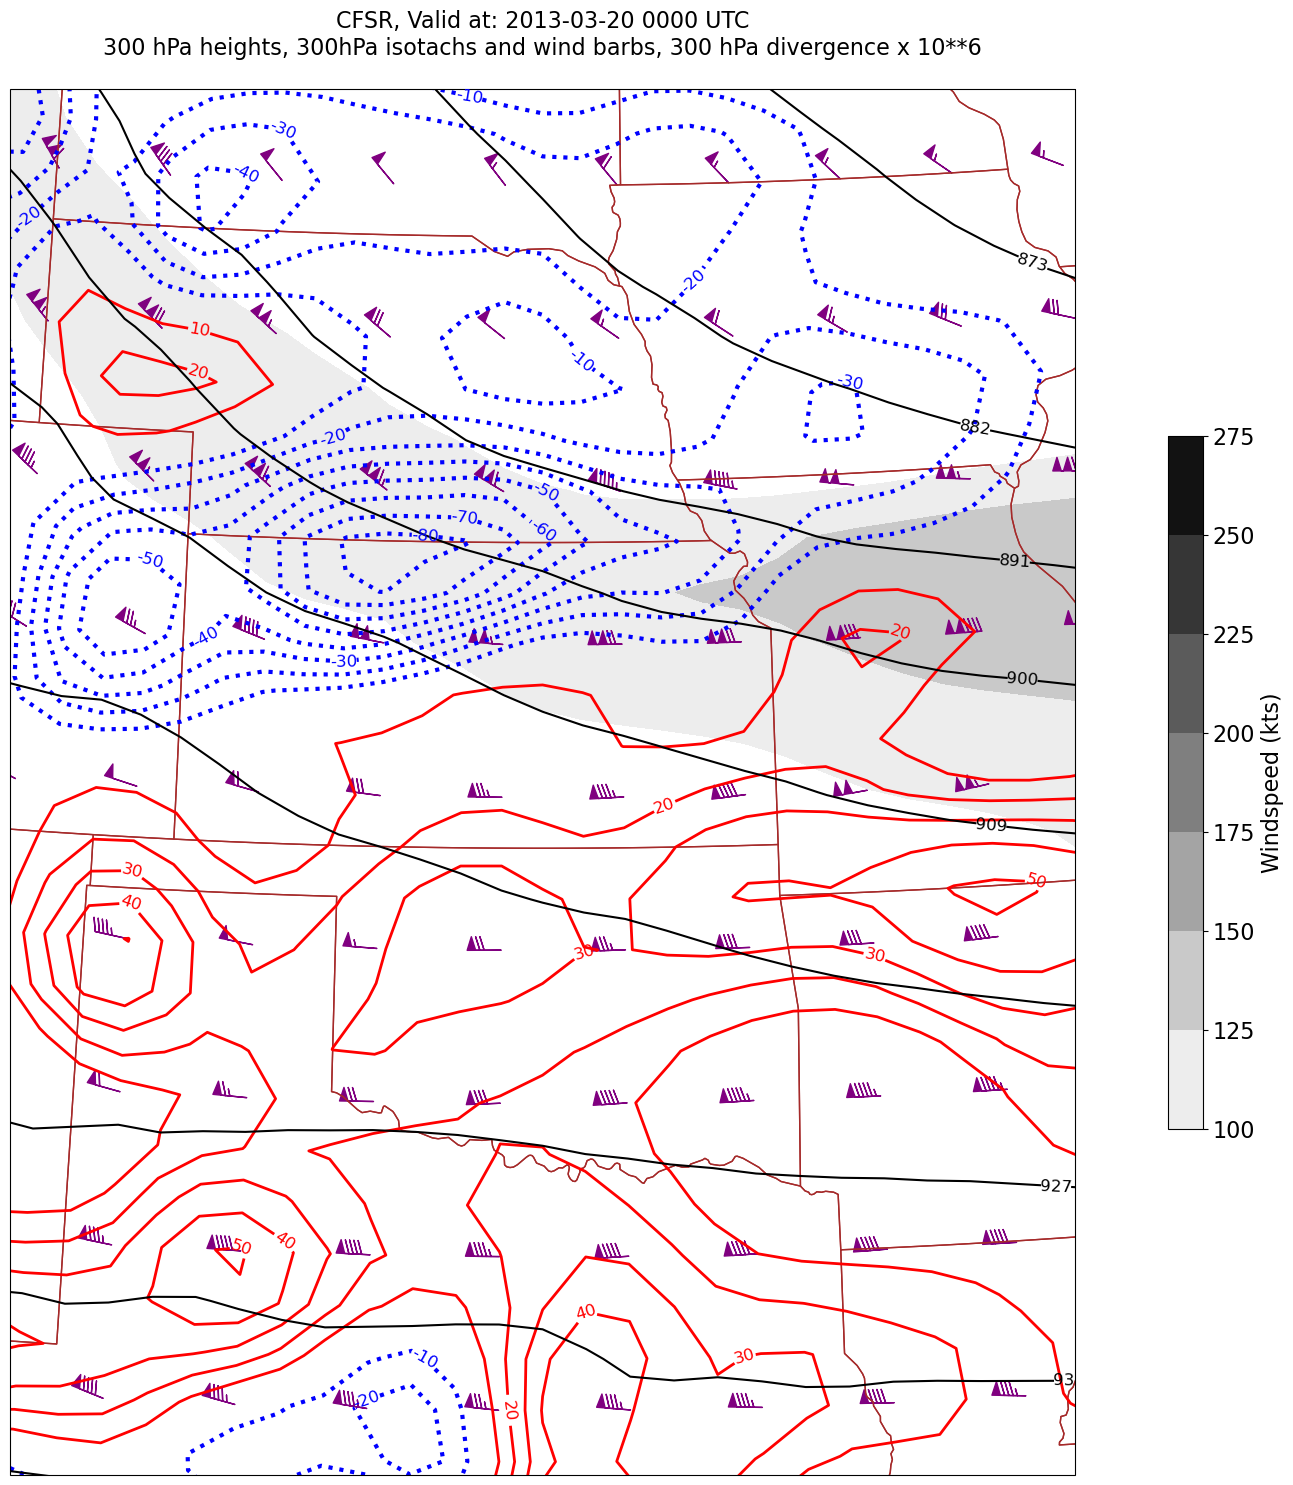

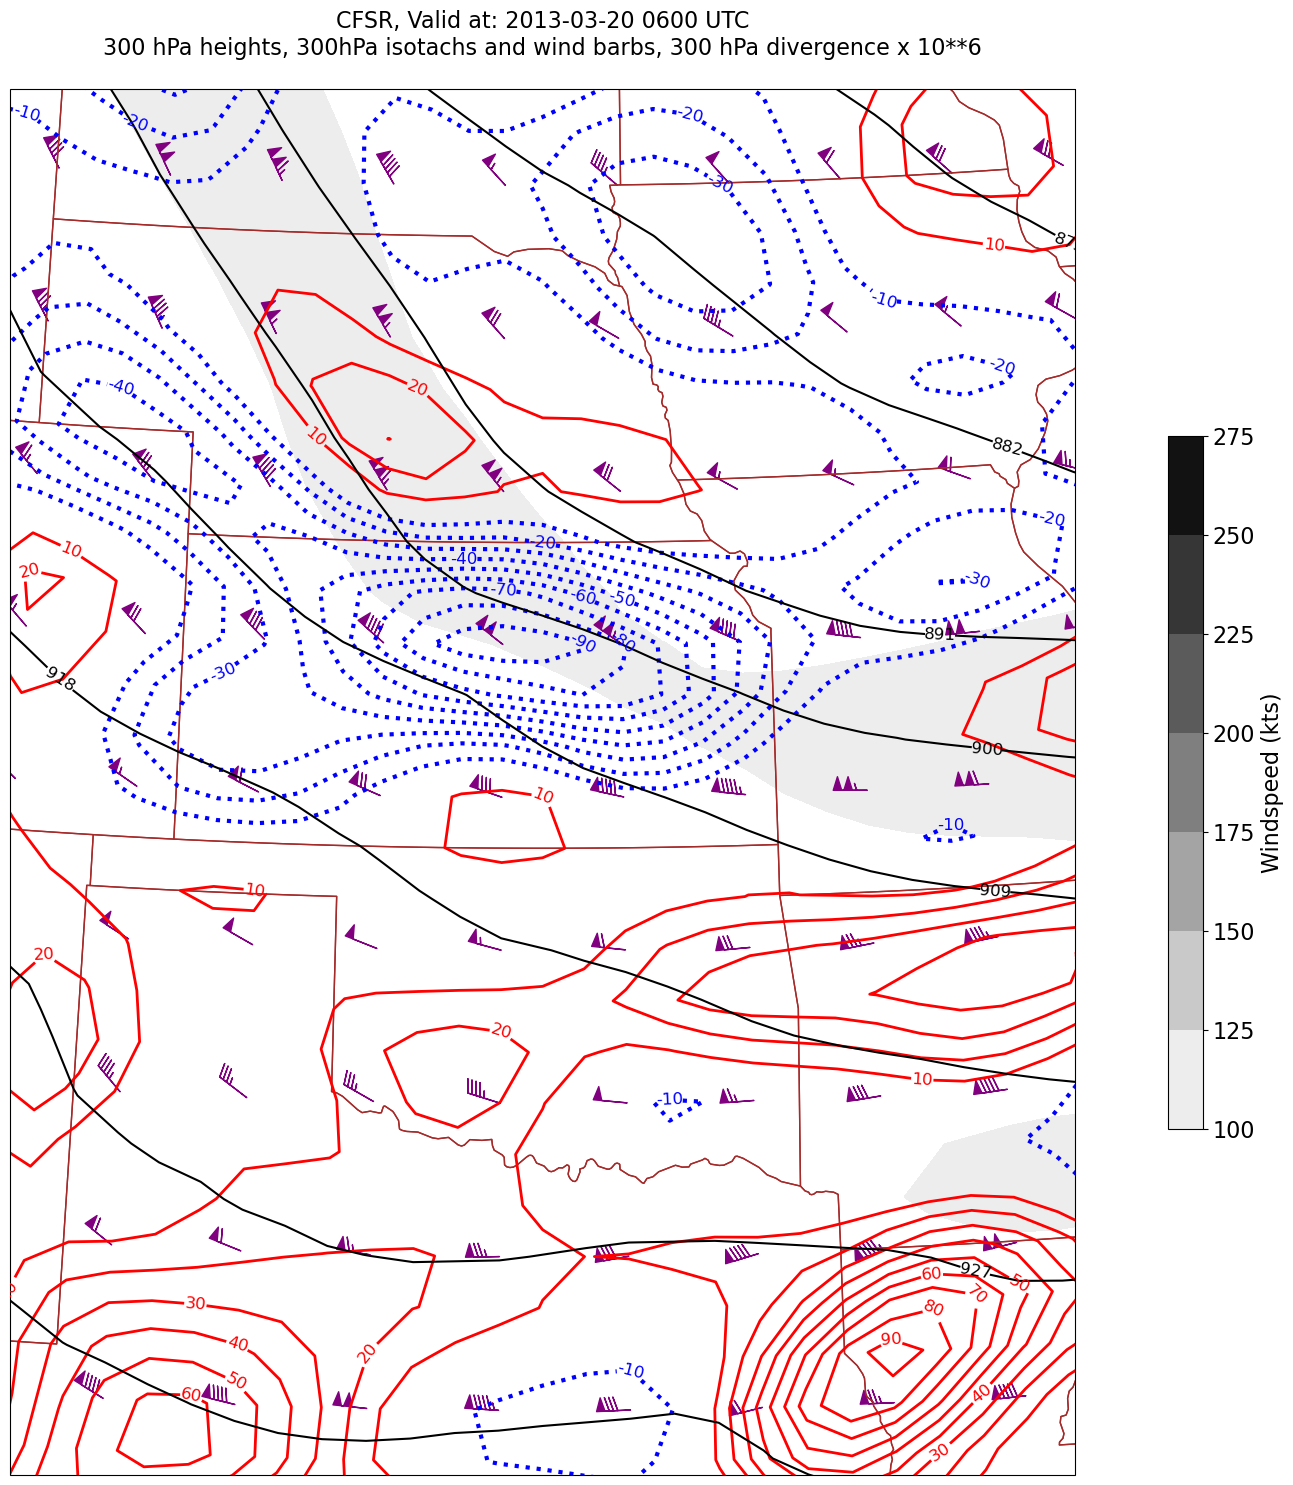

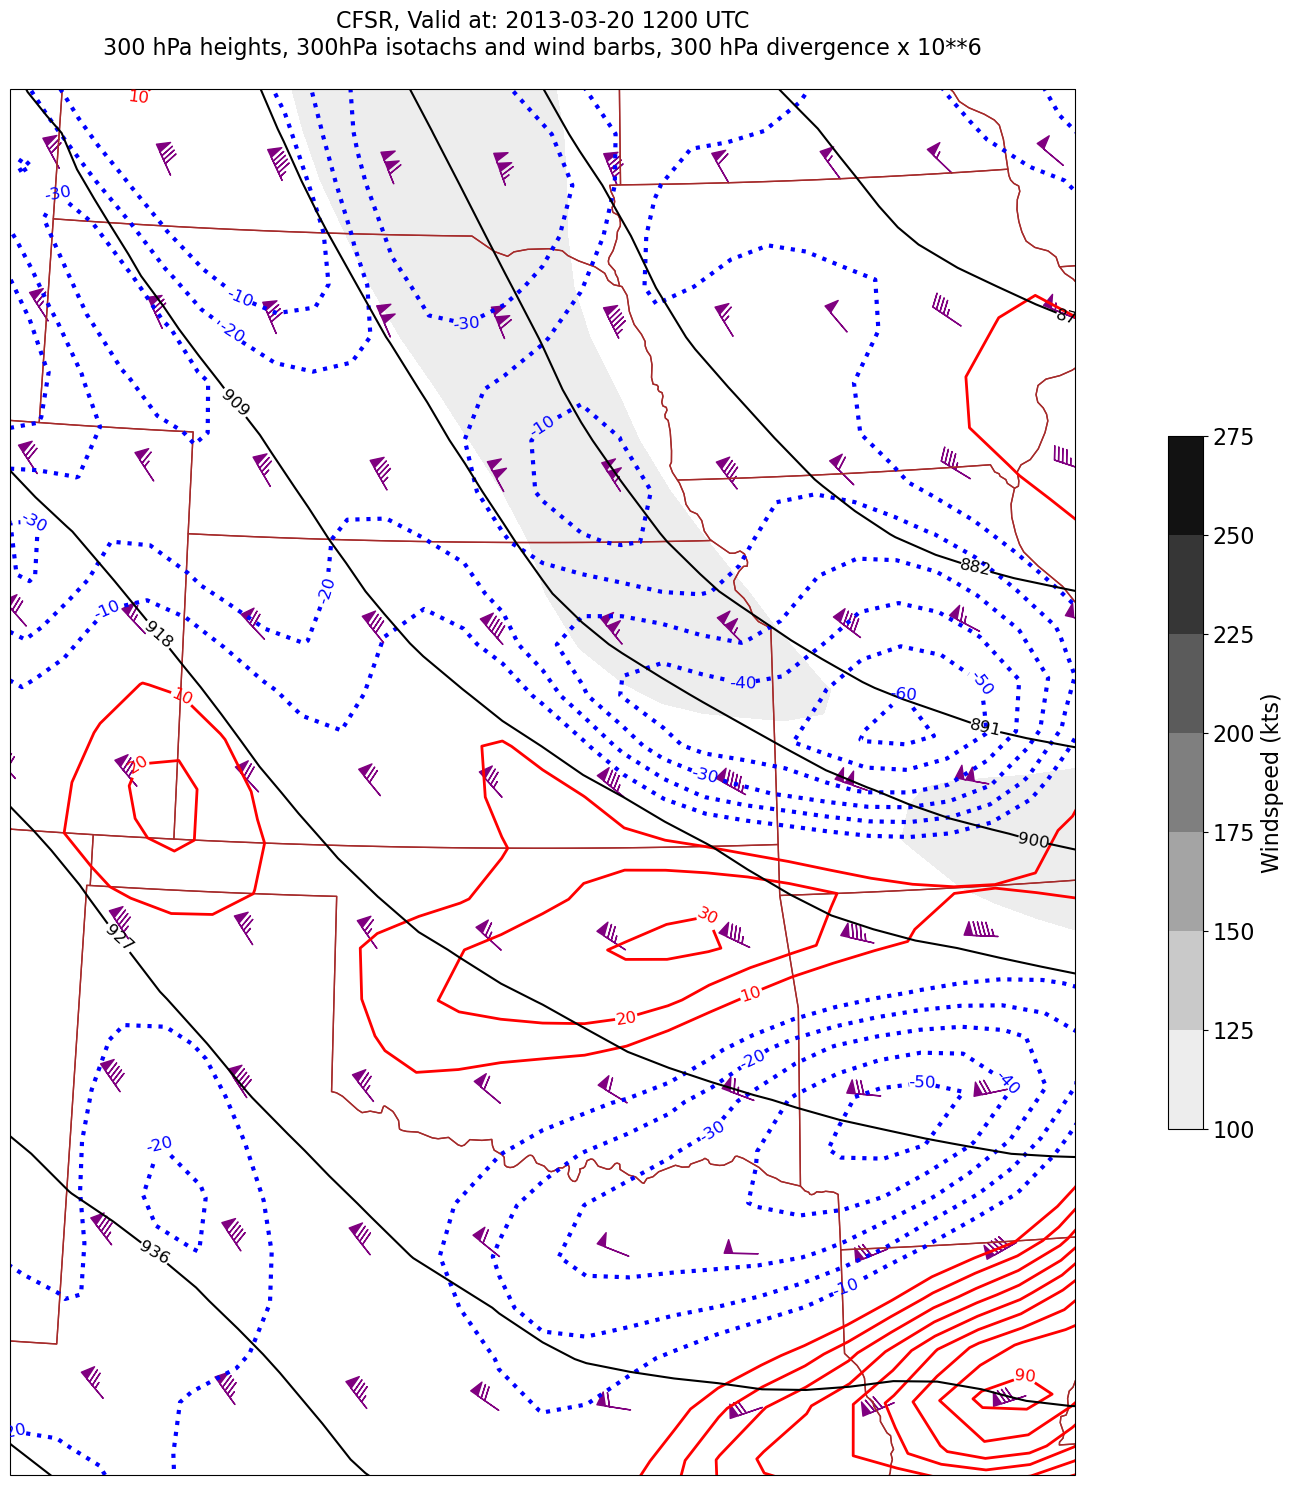

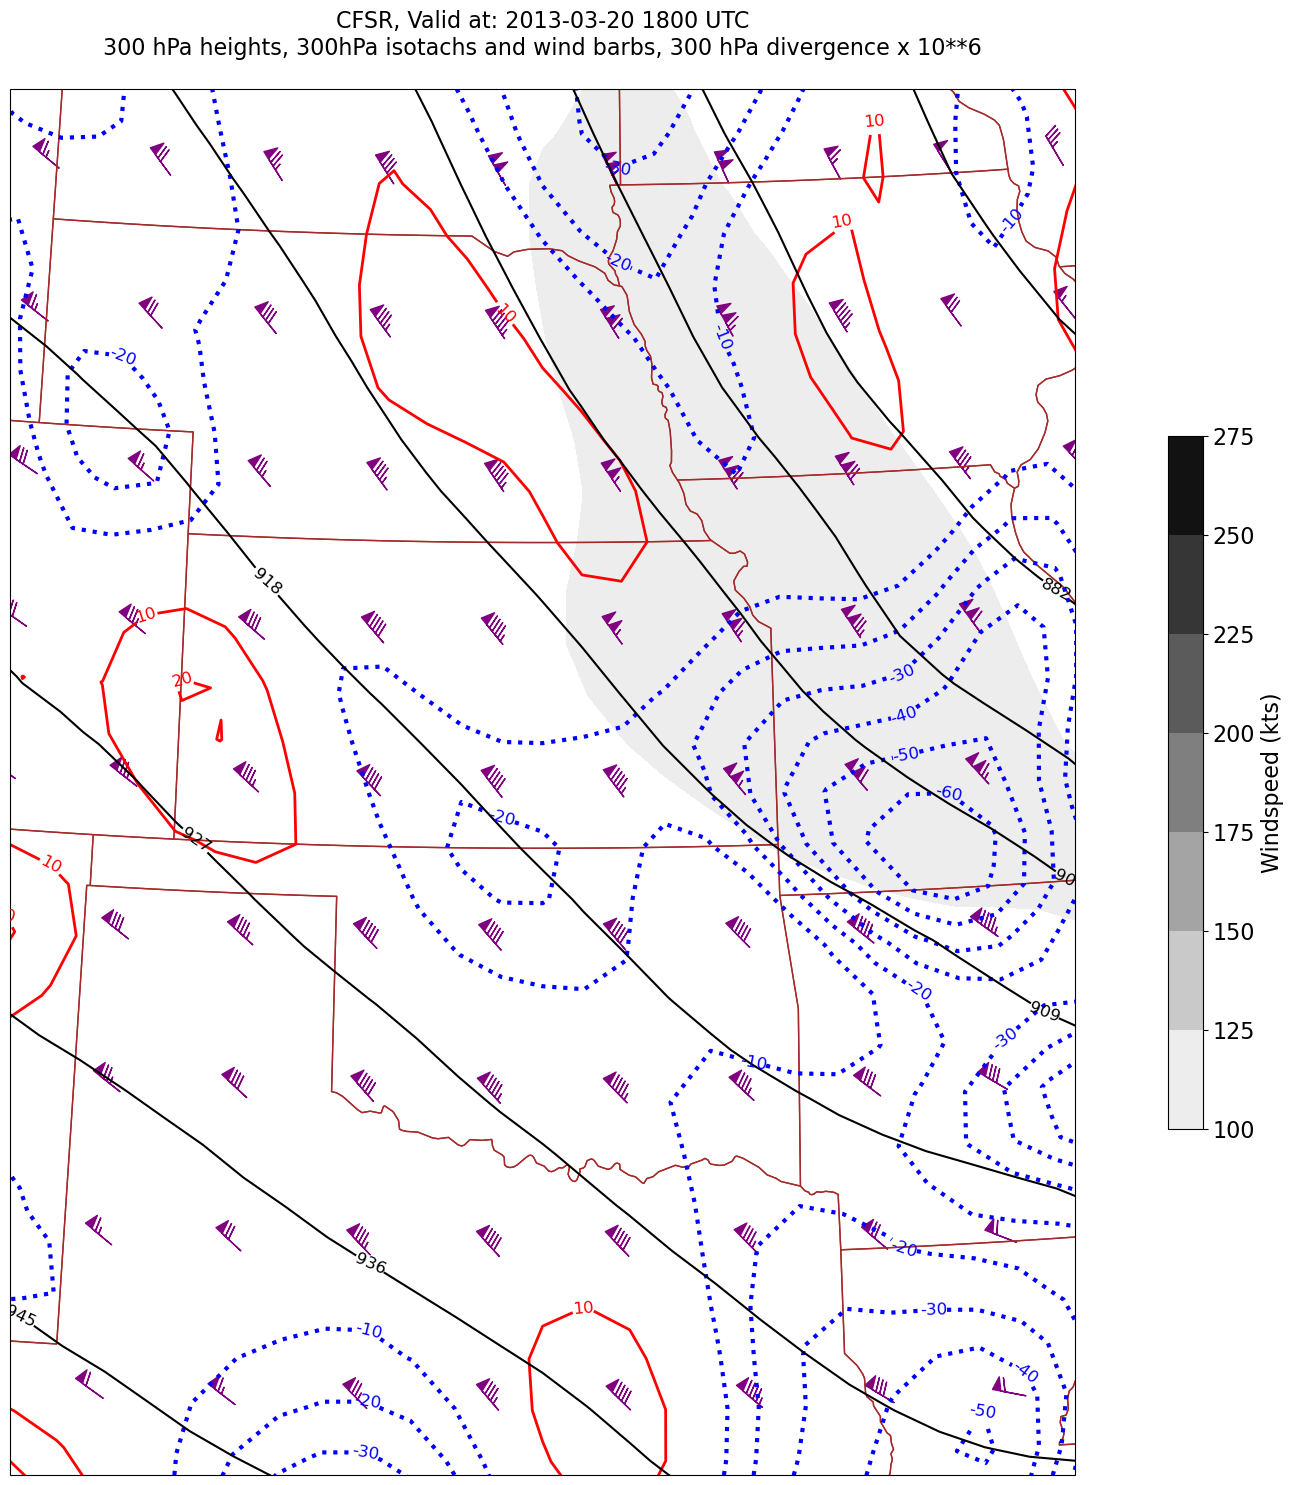

In [370]:
for time in dateList:
    print("Processing", time)
    
    # Create the time strings, for the figure title as well as for the file name.
    timeStr = dt.strftime(time,format="%Y-%m-%d %H%M UTC")
    timeStrFile = dt.strftime(time,format="%Y%m%d%H")
    
    tl2 = zLevStr + " hPa heights, " + windLevStr + "hPa isotachs and wind barbs, " + divLevStr + " hPa divergence x 10**6"
    tl1 = str('CFSR, Valid at: '+ timeStr)
    title_line = (tl1 + '\n' + tl2 + '\n')
    
    fig = plt.figure(figsize=(24,18)) # Increase size to adjust for the constrained lats/lons
    ax = plt.subplot(1,1,1,projection=proj_map)
    ax.set_extent ([lonW+constrainLon,lonE-constrainLon,latS+constrainLat,latN-constrainLat])
    ax.add_feature(cfeature.COASTLINE.with_scale(res))
    ax.add_feature(cfeature.STATES.with_scale(res),edgecolor='brown')
    
    # Need to use Xarray's sel method here to specify the current time for any DataArray you are plotting.
    # 1. Contour fills of isotachs
    CF = ax.contourf(lons,lats,WSPD.sel(time=time),levels=wspdContours,transform=proj_data,cmap='gist_gray_r')
    cbar = plt.colorbar(CF,shrink=0.5)
    cbar.ax.tick_params(labelsize=16)
    cbar.ax.set_ylabel("Windspeed (kts)",fontsize=16)

    # 2. Contour lines of divergence (first negative values, then positive)
    cDivNeg = ax.contour(lons, lats, divSmooth.sel(time=time), levels=negDivContours, colors='blue',linestyles='dotted',linewidths=3, transform=proj_data)
    ax.clabel(cDivNeg, inline=1, fontsize=12,fmt='%.0f')
    cDivPos = ax.contour(lons, lats, divSmooth.sel(time=time), levels=posDivContours, colors='red',linewidths=2, transform=proj_data)
    ax.clabel(cDivPos, inline=1, fontsize=12,fmt='%.0f')
    
    # 3. Contour lines of geopotential heights
    cZ = ax.contour(lons, lats, Z.sel(time=time), levels=zContours, colors='black', transform=proj_data)
    ax.clabel(cZ, inline=1, fontsize=12, fmt='%.0f')
    
    # 4. wind barbs
    # Plotting wind barbs uses the ax.barbs method. Here, you can't pass in the DataArray directly; you can only pass in the array's values.
    # Also need to sample (skip) a selected # of points to keep the plot readable.
    # Remember to use Xarray's sel method here as well to specify the current time.
    skip = 3
    ax.barbs(lons[::skip],lats[::skip],U.sel(time=time)[::skip,::skip].values, V.sel(time=time)[::skip,::skip].values, color='purple',transform=proj_data)

    title = plt.title(title_line,fontsize=16)
    
    #Generate a string for the file name and save the graphic to your current directory.
    fileName = timeStrFile + '_CFSR_WndDivHght'
    fig.savefig(fileName)